# Model de Machine Learning

In [128]:
    # Imports essentiels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Configuration d'affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Répertoires
ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = ROOT / 'data'
OUTPUT_DIR = ROOT / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Workspace : {ROOT}")
print(f"Data directory : {DATA_DIR}")


Workspace : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2
Data directory : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2\data


In [129]:
tx_processed = pd.read_csv(OUTPUT_DIR / "processed_data.csv")
print(f"Taille du dataset : {tx_processed.shape}")
print(tx_processed.head())

Taille du dataset : (251622, 20)
   hour  day_of_week  day_of_month  month  is_weekend  is_night  \
0     9            4             7      7           0         0   
1    17            0            26     11           0         0   
2    12            5            26      3           1         0   
3     8            0             1      2           0         0   
4    14            5            24      3           1         0   

   amount_parsed  amount_abs  is_negative_amount  mcc_encoded  \
0      -0.374405   -0.536427                 0.0           78   
1       0.195082    0.078960                 0.0           71   
2      -0.390768   -0.554109                 0.0           56   
3       0.535361    0.446665                 0.0           56   
4      -0.361017   -0.521960                 0.0           37   

   merchant_id_encoded  use_chip_encoded  merchant_city_encoded  \
0                 1653                 0                    169   
1                13360                 

In [130]:
# Définir X et y
feature_cols = [col for col in tx_processed.columns if col != 'is_fraud']
X = tx_processed[feature_cols]
y = tx_processed['is_fraud']

print("Features utilisées :", feature_cols)
print(f"Nombre d'observations : {len(X)}")

Features utilisées : ['hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night', 'amount_parsed', 'amount_abs', 'is_negative_amount', 'mcc_encoded', 'merchant_id_encoded', 'use_chip_encoded', 'merchant_city_encoded', 'merchant_state_encoded', 'has_zip', 'has_error', 'card_type_encoded', 'credit_limit_log', 'user_age']
Nombre d'observations : 251622


In [131]:
# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train : {X_train.shape}, Test : {X_test.shape}")


Train : (201297, 19), Test : (50325, 19)


### Entraînement du modèle (Random Forest)

Random Forest — Évaluation :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41938
           1       1.00      1.00      1.00      8387

    accuracy                           1.00     50325
   macro avg       1.00      1.00      1.00     50325
weighted avg       1.00      1.00      1.00     50325

AUC : 0.9999


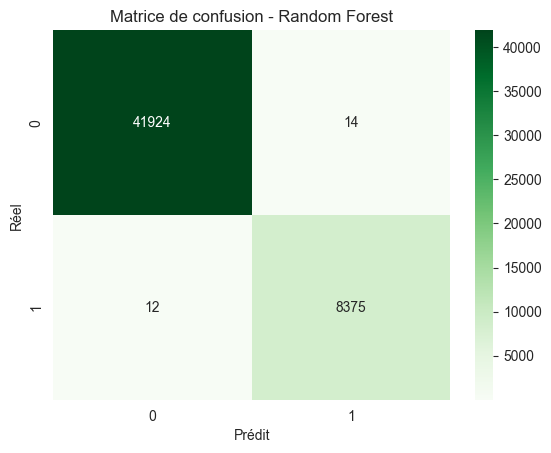

C:\Users\romai\AppData\Local\Temp\ipykernel_14424\1497957923.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


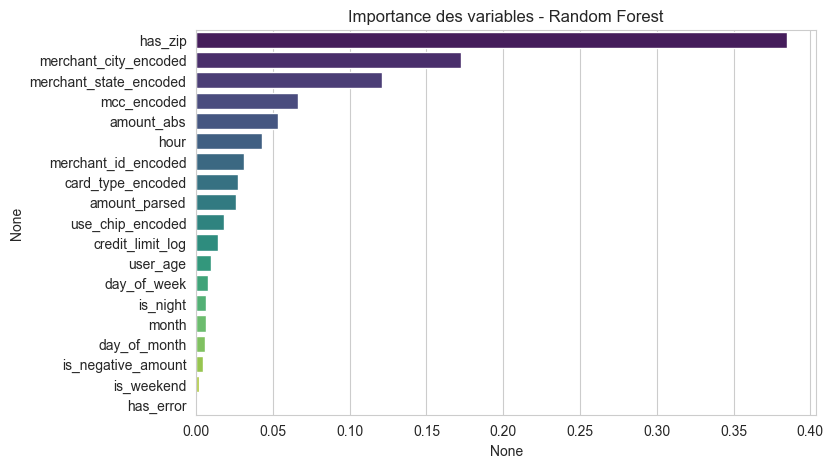

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest — Évaluation :\n")
print(classification_report(y_test, y_pred_rf))
print(f"AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Importance des variables
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Importance des variables - Random Forest")
plt.show()

### Régression Logistic

Régression Logistique — Évaluation :

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     41938
           1       0.60      0.99      0.74      8387

    accuracy                           0.89     50325
   macro avg       0.80      0.93      0.84     50325
weighted avg       0.93      0.89      0.90     50325

AUC : 0.9646


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


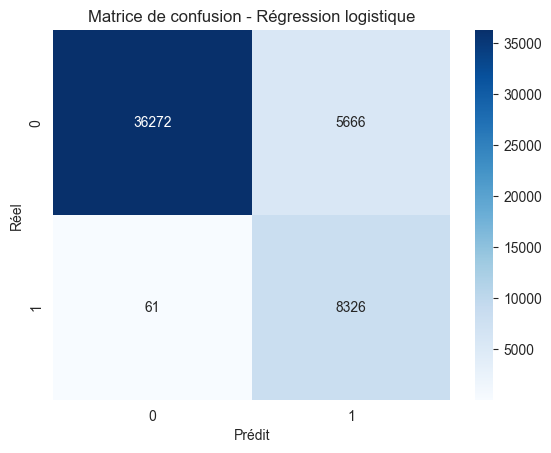

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Régression Logistique — Évaluation :\n")
print(classification_report(y_test, y_pred_lr))
print(f"AUC : {roc_auc_score(y_test, y_proba_lr):.4f}")

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - Régression logistique")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

### XGBoost

XGBoost — Évaluation :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41938
           1       1.00      1.00      1.00      8387

    accuracy                           1.00     50325
   macro avg       1.00      1.00      1.00     50325
weighted avg       1.00      1.00      1.00     50325

AUC : 1.0000


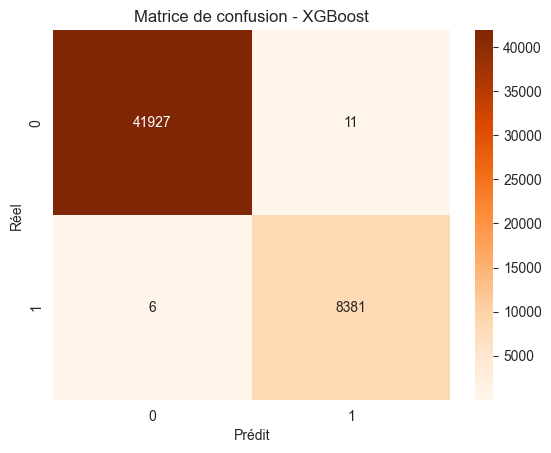

In [134]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost — Évaluation :\n")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC : {roc_auc_score(y_test, y_proba_xgb):.4f}")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

### Comparaison entre modèles

Résumé comparatif des modèles :


,Accuracy,Precision,Recall,F1-score,AUC
Model,,,,,
Logistic Regression,0.886200,0.595054,0.992727,0.744090,0.964606
Random Forest,0.999483,0.998331,0.998569,0.998450,0.999922
XGBoost,0.999662,0.998689,0.999285,0.998987,0.999985


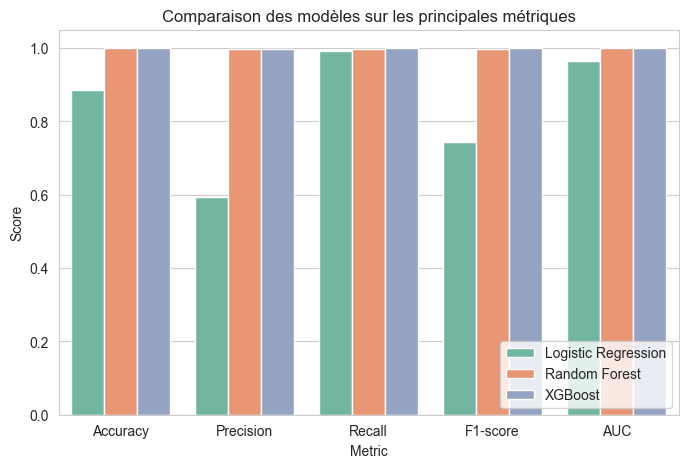

In [135]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

print("Résumé comparatif des modèles :")
display(results.set_index("Model"))

# Visualisation
plt.figure(figsize=(8,5))
sns.barplot(data=results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Metric', y='Score', hue='Model', palette='Set2')
plt.title("Comparaison des modèles sur les principales métriques")
plt.legend(loc='lower right')
plt.show()

On a décidé de garder XGBoost comme modèle final, car c’est celui qui obtient les meilleures performances globales sur l’ensemble des métriques (Accuracy, Recall, F1-score et AUC).
Il gère bien les données déséquilibrées et capte efficacement les relations non linéaires, ce qui en fait le modèle le plus performant et le plus fiable pour la détection de fraude.

## Conclusion

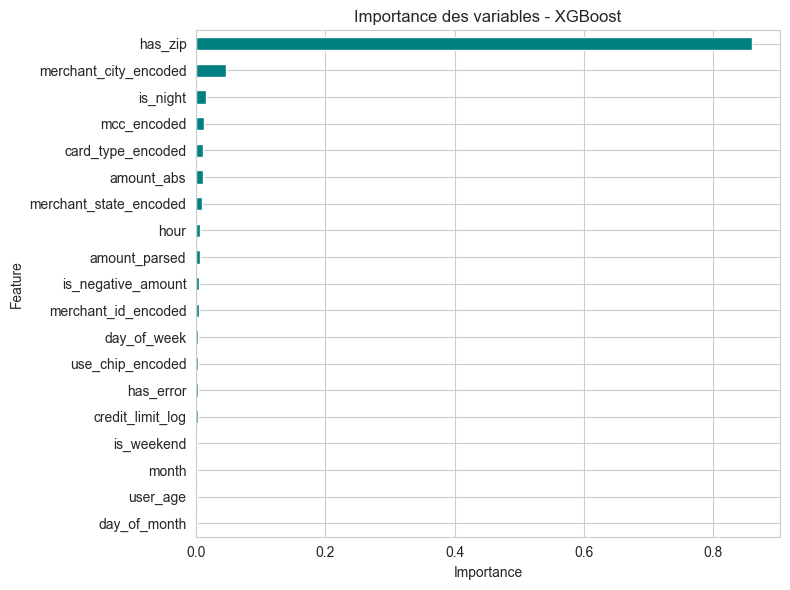

In [136]:
# Importance des features selon XGBoost
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='teal')
plt.title("Importance des variables - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [137]:
import joblib
import os

# Création du dossier 'models' si nécessaire
os.makedirs(OUTPUT_DIR/"models", exist_ok=True)

# Sauvegarde du modèle XGBoost
joblib.dump(xgb, OUTPUT_DIR/"models/xgboost_fraud_model.pkl")

print("Modèle XGBoost sauvegardé sous : output/models/xgboost_fraud_model.pkl")

Modèle XGBoost sauvegardé sous : output/models/xgboost_fraud_model.pkl


In [138]:
# Pour réutiliser le modèle plus tard :
xgb_loaded = joblib.load(OUTPUT_DIR/"models/xgboost_fraud_model.pkl")

# Test rapide
sample_pred = xgb_loaded.predict(X_test[:5])
print("Prédiction du modèle chargé :", sample_pred)

eval_data = pd.read_csv(DATA_DIR/"evaluation_features.csv")
eval_data.head()


Prédiction du modèle chargé : [0 0 0 1 0]


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,23042130,2019-06-01 14:41:00,900,3412,$118.61,Swipe Transaction,61195,Panama City,FL,32401.0,5541,NaN
1,22702314,2019-03-21 13:45:00,1741,3025,$-204.00,Chip Transaction,49637,Tucson,AZ,85736.0,3509,NaN
2,22838524,2019-04-19 11:53:00,1081,3892,$-99.00,Chip Transaction,43293,Aurora,CO,80013.0,5499,NaN
3,23477219,2019-09-01 11:46:00,1740,2382,$28.44,Chip Transaction,26032,Mukwonago,WI,53149.0,7210,NaN
4,23066897,2019-06-06 21:24:00,1207,6056,$32.02,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN


In [139]:
# Chargement des jeux de données de référence
cards = pd.read_csv(DATA_DIR/"cards_data.csv")
users = pd.read_csv(DATA_DIR/"users_data.csv")

# Si tu veux, tu peux aussi charger les codes MCC
import json
with open(DATA_DIR/"mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Copie du dataset à évaluer
eval_df = eval_data.copy()

# === 1. Harmoniser les types d'identifiants ===
eval_df['card_id'] = eval_df['card_id'].astype(str)
eval_df['client_id'] = eval_df['client_id'].astype(str)
cards['id'] = cards['id'].astype(str)
users['id'] = users['id'].astype(str)

# === 2. Fusionner les datasets ===
eval_df = eval_df.merge(cards, left_on='card_id', right_on='id', how='left', suffixes=('', '_card'))
eval_df = eval_df.merge(users, left_on='client_id', right_on='id', how='left', suffixes=('', '_user'))

# === 3. Enrichir le MCC (optionnel)
eval_df['mcc_desc'] = eval_df['mcc'].map(mcc_dict)

print(f"Shape après fusion : {eval_df.shape}")
print(f"Colonnes disponibles : {list(eval_df.columns)}")


Shape après fusion : (90000, 40)
Colonnes disponibles : ['transaction_id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'id', 'client_id_card', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web', 'id_user', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'mcc_desc']


In [140]:
# --- 0. Fusion avec les données cartes et utilisateurs ---
cards = pd.read_csv(DATA_DIR/"cards_data.csv")
users = pd.read_csv(DATA_DIR/"users_data.csv")

# Harmoniser les clés
eval_df['card_id'] = eval_df['card_id'].astype(str)
eval_df['client_id'] = eval_df['client_id'].astype(str)
cards['id'] = cards['id'].astype(str)
users['id'] = users['id'].astype(str)

# Fusion
eval_df = eval_df.merge(cards, left_on='card_id', right_on='id', how='left', suffixes=('', '_card'))
eval_df = eval_df.merge(users, left_on='client_id', right_on='id', how='left', suffixes=('', '_user'))

# --- 1. Nettoyage et création des variables monétaires ---
eval_df['amount_parsed'] = pd.to_numeric(eval_df['amount'], errors='coerce')
eval_df['amount_abs'] = eval_df['amount_parsed'].abs()
eval_df['is_negative_amount'] = (eval_df['amount_parsed'] < 0).astype(int)

# --- 2. Extraction des variables temporelles ---
eval_df['date'] = pd.to_datetime(eval_df['date'], errors='coerce')
eval_df['hour'] = eval_df['date'].dt.hour
eval_df['day_of_week'] = eval_df['date'].dt.dayofweek
eval_df['day_of_month'] = eval_df['date'].dt.day
eval_df['month'] = eval_df['date'].dt.month
eval_df['is_weekend'] = eval_df['day_of_week'].isin([5, 6]).astype(int)
eval_df['is_night'] = eval_df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)

# --- 3. Variables indicatrices ---
eval_df['has_zip'] = eval_df['zip'].notnull().astype(int)
eval_df['has_error'] = eval_df['errors'].notnull().astype(int)

# --- 4. Encodage des variables catégorielles ---
from sklearn.preprocessing import LabelEncoder
for col in ['mcc', 'merchant_id', 'use_chip', 'merchant_city', 'merchant_state', 'card_type', 'user_country']:
    if col in eval_df.columns:
        le = LabelEncoder()
        eval_df[col + '_encoded'] = le.fit_transform(eval_df[col].fillna('MISSING'))

# --- 5. Features dérivées des infos carte et utilisateur ---
if 'credit_limit' in eval_df.columns:
    eval_df['credit_limit'] = (
        eval_df['credit_limit']
        .replace('[^0-9.-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )
    eval_df['credit_limit_log'] = np.log1p(eval_df['credit_limit'])

if 'birth_year' in eval_df.columns:
    eval_df['user_age'] = 2025 - eval_df['birth_year']

# --- 6. Normalisation des montants ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eval_df[['amount_parsed', 'amount_abs']] = scaler.fit_transform(
    eval_df[['amount_parsed', 'amount_abs']]
)

# --- 7. Sélection des mêmes features que pour le modèle ---
feature_cols = [
    'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend',
    'is_night', 'amount_parsed', 'amount_abs', 'is_negative_amount',
    'mcc_encoded', 'merchant_id_encoded', 'use_chip_encoded',
    'merchant_city_encoded', 'merchant_state_encoded',
    'has_zip', 'has_error', 'card_type_encoded',
    'credit_limit_log', 'user_age'
]

# --- 8. Construction du DataFrame final pour le modèle ---
eval_df_model = eval_df[feature_cols].astype('float32')


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [141]:


y_pred = xgb.predict(eval_df_model)
submission = pd.DataFrame({
    "transaction_id": eval_data["transaction_id"],
    "fraud_prediction": y_pred
})
submission.head()

,transaction_id,fraud_prediction
0,23042130,0
1,22702314,0
2,22838524,0
3,23477219,0
4,23066897,0


=== Statistiques des prédictions du modèle ===
Total des transactions évaluées : 90,000
Non frauduleuses : 89,499 (99.44%)
Frauduleuses     : 501 (0.56%)
Taux de fraude prédit : 0.557%


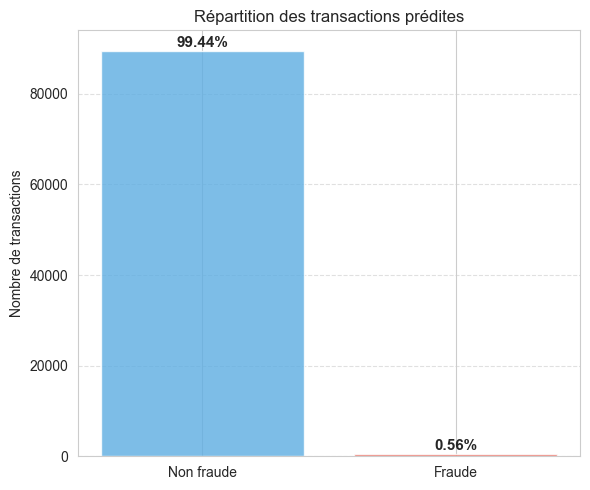

In [143]:
# Comptage des prédictions
fraud_counts = submission["fraud_prediction"].value_counts().sort_index()
total_preds = len(submission)
fraud_percent = fraud_counts.get(1, 0) / total_preds * 100
nonfraud_percent = fraud_counts.get(0, 0) / total_preds * 100

print("=== Statistiques des prédictions du modèle ===")
print(f"Total des transactions évaluées : {total_preds:,}")
print(f"Non frauduleuses : {fraud_counts.get(0, 0):,} ({nonfraud_percent:.2f}%)")
print(f"Frauduleuses     : {fraud_counts.get(1, 0):,} ({fraud_percent:.2f}%)")
print(f"Taux de fraude prédit : {fraud_percent:.3f}%")

# Visualisation
plt.figure(figsize=(6,5))
bars = plt.bar(
    ['Non fraude', 'Fraude'],
    [fraud_counts.get(0, 0), fraud_counts.get(1, 0)],
    color=['#5dade2', '#e74c3c'],
    alpha=0.8
)
plt.title("Répartition des transactions prédites")
plt.ylabel("Nombre de transactions")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les pourcentages sur les barres
for bar, pct in zip(bars, [nonfraud_percent, fraud_percent]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + total_preds*0.002,
        f"{pct:.2f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


In [1]:
import xgboost as xgb
print(xgb.__version__)


3.1.1
